# 1. Data Pre-Processing

### Import Library

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Folder Paths

In [3]:
# source_folder = folder penyimpanan kumpulan dataset yang masih tercampur atau belum dibagi menjadi train, test, dan validation
source_folder = "../dataset/ICDAR-2011"
# train_folder, test_folder, validation_folder = folder tujuan / tempat penyimpanan dataset setelah dibagi di bagian "Train and Test Data Split" 
train_folder = "../template/ICDAR-data/train"
test_folder = "../template/ICDAR-data/test"
validation_folder = "../template/ICDAR-data/validation"

### Train and Test Data Split

In [4]:
# Hanya membagi data, belum read / membaca gambar 

In [5]:
def extract_label(folder_name):
    return 0 if "_forg" in folder_name else 1

def split_data(source_folder, train_folder, test_folder, validation_folder):
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)
    if not os.path.exists(validation_folder):
        os.makedirs(validation_folder)

    signatures = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder))]
    for signature in signatures:
        signature_path = os.path.join(source_folder, signature)
        images = os.listdir(signature_path)

        label = extract_label(signature)

        train_signature_temp, test_signature = train_test_split(images, test_size=0.2, random_state=3, stratify=[label]*len(images)) #stratify
        train_signature, validation_signature = train_test_split(train_signature_temp, test_size=0.25, random_state=3, stratify=[label]*len(train_signature_temp))

        for sig in train_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(train_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in test_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(test_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in validation_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(validation_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

In [6]:
# split_data(source_folder, train_folder, test_folder, validation_folder)

# 2. Feature Extraction

### Load vgg16 model

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

### Extract Features

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2 as cv

In [9]:
size = 224

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
gap = GlobalAveragePooling2D()(base_model.output) 
gap = Dense(512, activation='relu')(gap) # Global Average Pooling to 512

In [11]:
model = Model(inputs=base_model.input, outputs=gap)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [14]:
# train_features, train_names, train_labels = extract_features(train_folder)
# test_features, test_names, test_labels = extract_features(test_folder)
# validation_features, validation_names, validation_labels = extract_features(validation_folder)

### Save and Load Features, Names, and Labels to reduce time needed

In [15]:
train_features_path =  "../template/ICDAR-feature/train_features.npy"
train_names_path = "../template/ICDAR-feature/train_names.npy"
train_labels_path = "../template/ICDAR-feature/train_labels.npy"

test_features_path = "../template/ICDAR-feature/test_features.npy"
test_names_path = "../template/ICDAR-feature/test_names.npy"
test_labels_path = "../template/ICDAR-feature/test_labels.npy"

validation_features_path = "../template/ICDAR-feature/validation_features.npy"
validation_names_path = "../template/ICDAR-feature/validation_names.npy"
validation_labels_path = "../template/ICDAR-feature/validation_labels.npy"

In [16]:
# np.save(train_features_path, train_features)
# np.save(train_names_path, train_names)
# np.save(train_labels_path, train_labels)

# np.save(test_features_path, test_features)
# np.save(test_names_path, test_names)
# np.save(test_labels_path, test_labels)

# np.save(validation_features_path, validation_features)
# np.save(validation_names_path, validation_names)
# np.save(validation_labels_path, validation_labels)

In [17]:
train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

In [18]:
print("train_features shape : ", train_features.shape)
print("test_features shape : ", test_features.shape)
print("validation_features shape : ", validation_features.shape)

train_features shape :  (857, 512)
test_features shape :  (401, 512)
validation_features shape :  (391, 512)


### Feature Gallery

In [19]:
# Feature Gallery dilakukan untuk setiap kelas / nama seperti "001", "002", "003", dst dengan cara mengambil data training positive dan mengambil mean / rata-rata dari data tersebut
def create_feature_gallery(train_features, train_names, train_labels):
    gallery_feature = []
    gallery_name = []

    unique_names = set(train_names.flatten())
    sorted_names = sorted(unique_names)

    for name in sorted_names:
        # print(name)
        # print(name)
        name_features = []

        for feature, feature_name, label in zip(train_features, train_names, train_labels):
            # print(feature, feature_name, label)
            if name in feature_name and label == 1:
                name_features.append(feature)

        if name_features:
            # print(name_features)
            average_feature = np.mean(name_features, axis=0)
            gallery_feature.append(average_feature)
            gallery_name.append(name)

    return gallery_feature, gallery_name

In [20]:
gallery_features, gallery_names = create_feature_gallery(train_features, train_names, train_labels)

In [21]:
gallery_features_array = np.array(gallery_features)
print("gallery features shape : ", gallery_features_array.shape)

gallery features shape :  (64, 512)


### Euclidean Distance

In [22]:
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1 - feature_vector2)**2))

In [23]:
def find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names):
    euclidean_distances = []
    euclidean_names = []
    euclidean_actual_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_euclid_name = gallery_name
        curr_euclid_feature = []
        curr_euclid_label = []
        curr_euclid_dist = []
        for feature, name, label in zip(test_features, test_names, test_labels):
            if gallery_name in name:
                curr_euclid_feature.append(feature)
                curr_euclid_label.append(label)
        
        for feature in curr_euclid_feature:
            distance = euclidean_distance(feature, gallery_feature)
            curr_euclid_dist.append(distance)

        euclidean_distances.append(curr_euclid_dist)
        euclidean_names.append(curr_euclid_name)
        euclidean_actual_labels.append(curr_euclid_label)
        
    return euclidean_distances, euclidean_names, euclidean_actual_labels

In [24]:
#test dengan train

In [25]:
test_euclidean_distances, test_euclidean_names, test_euclidean_actual_labels = find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names)
train_euclidean_distances, train_euclidean_names, train_euclidean_actual_labels = find_euclidean_distance(train_features, train_names, train_labels, gallery_features, gallery_names)
validation_euclidean_distances, validation_euclidean_names, validation_euclidean_actual_labels = find_euclidean_distance(validation_features, validation_names, validation_labels, gallery_features, gallery_names)

In [26]:
# print(euclidean_actual_labels)

### Split Euclidean Distance to Positive and Negative for Future Use (If needed)

In [27]:
# # for machine learning purposes
# positive_distance = []
# positive_name = []
# positive_label = []
# negative_distance = []
# negative_name = []
# negative_label = []

# for euclidean_distance, euclidean_name, euclidean_actual_label in zip(euclidean_distances, euclidean_names, euclidean_actual_labels):
#     pos_dist = []
#     neg_dist = []
#     pos_lab = []
#     neg_lab = []
#     for distance, label in zip(euclidean_distance, euclidean_actual_label):
#         if label == 0:
#             neg_dist.append(distance)
#             neg_lab.append(label)
#         else:
#             pos_dist.append(distance)
#             pos_lab.append(label)

#     positive_distance.append(pos_dist)
#     positive_name.append(euclidean_name)
#     positive_label.append(pos_lab)

#     negative_distance.append(neg_dist)
#     negative_name.append(euclidean_name)
#     negative_label.append(neg_lab)
#     # print(euclidean_distance, euclidean_name, euclidean_actual_label)

### Normalize Euclidean Distance

In [28]:
def normalize_distance(euclidean_distances):
    all_distances = []
    for distances in euclidean_distances:
        min_distance = min(distances)
        max_distance = max(distances)

        normalized_distances = [(d - min_distance) / (max_distance - min_distance) for d in distances]
        all_distances.append(normalized_distances)

    return all_distances

def reverse_normalized_distance(euclidean_distances):
    reverse_distance = []
    normalized_distances = normalize_distance(euclidean_distances)
    for distances in normalized_distances:
        temp = []
        for distance in distances :
            distance = -distance
            temp.append(distance)
        reverse_distance.append(temp)
    return reverse_distance

In [29]:
# normalized_positive_distances = reverse_normalized_distance(positive_distance)
# normalized_negative_distances = reverse_normalized_distance(negative_distance)

In [30]:
normalized_test_euclidean_distance = reverse_normalized_distance(test_euclidean_distances)
normalized_train_euclidean_distance = reverse_normalized_distance(train_euclidean_distances)
normalized_validation_euclidean_distance = reverse_normalized_distance(validation_euclidean_distances)

# 3. ROC Curve

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

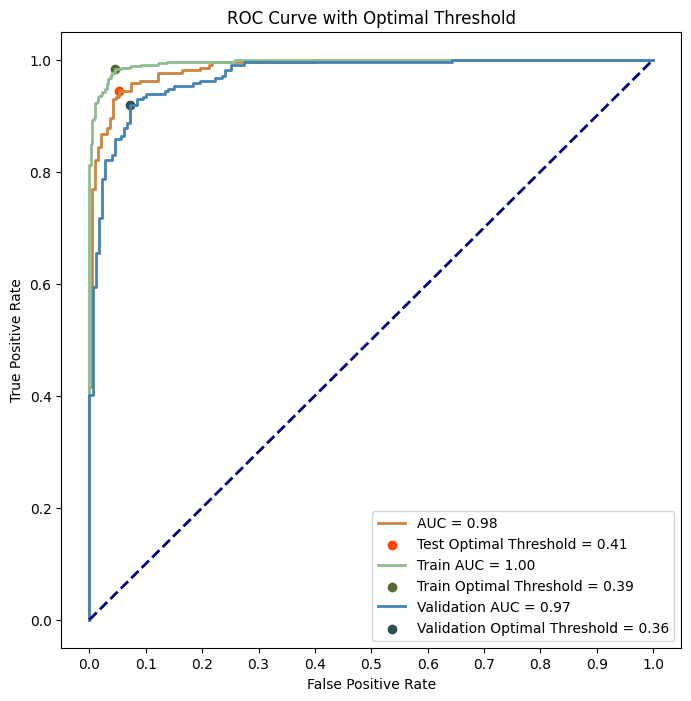

In [32]:
# Flatten the lists of distances
flat_test_distances = [item for sublist in normalized_test_euclidean_distance for item in sublist]
flat_train_distances = [item for sublist in normalized_train_euclidean_distance for item in sublist]
flat_validation_distances = [item for sublist in normalized_validation_euclidean_distance for item in sublist]

# Flatten the lists of labels
flat_test_labels = [item for sublist in test_euclidean_actual_labels for item in sublist]
flat_train_labels = [item for sublist in train_euclidean_actual_labels for item in sublist]
flat_validation_labels = [item for sublist in validation_euclidean_actual_labels for item in sublist]

# Calculate ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(flat_test_labels, flat_test_distances)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, thresholds_train = roc_curve(flat_train_labels, flat_train_distances)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_validation, tpr_validation, thresholds_validation = roc_curve(flat_validation_labels, flat_validation_distances)
roc_auc_validation = auc(fpr_validation, tpr_validation)

# Calculate Youden's J statistic
J_values_test = tpr_test - fpr_test
optimal_idx_test = np.argmax(J_values_test)
optimal_threshold_test = abs(thresholds_test[optimal_idx_test])
J_values_train = tpr_train - fpr_train
optimal_idx_train = np.argmax(J_values_train)
optimal_threshold_train = abs(thresholds_train[optimal_idx_train])
J_values_validation = tpr_validation - fpr_validation
optimal_idx_validation = np.argmax(J_values_validation)
optimal_threshold_validation = abs(thresholds_validation[optimal_idx_validation])

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')
plt.scatter(fpr_test[optimal_idx_test], tpr_test[optimal_idx_test], marker='o', color='orangered', label=f'Test Optimal Threshold = {optimal_threshold_test:.2f}')
plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')
plt.scatter(fpr_train[optimal_idx_train], tpr_train[optimal_idx_train], marker='o', color='darkolivegreen', label=f'Train Optimal Threshold = {optimal_threshold_train:.2f}')
plt.plot(fpr_validation, tpr_validation, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_validation:.2f}')
plt.scatter(fpr_validation[optimal_idx_validation], tpr_validation[optimal_idx_validation], marker='o', color='darkslategray', label=f'Validation Optimal Threshold = {optimal_threshold_validation:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
plt.legend(loc='lower right')
plt.show()

In [33]:
print(tpr_test)

[0.         0.30188679 0.41509434 0.41509434 0.76886792 0.76886792
 0.82075472 0.82075472 0.84433962 0.84433962 0.86792453 0.86792453
 0.87735849 0.87735849 0.89622642 0.89622642 0.92924528 0.92924528
 0.93396226 0.93396226 0.94339623 0.94339623 0.95754717 0.95754717
 0.96226415 0.96226415 0.97641509 0.97641509 0.98113208 0.98113208
 0.98584906 0.98584906 0.99056604 0.99056604 0.99528302 0.99528302
 1.         1.         1.        ]


In [34]:
print(fpr_test)

[0.         0.         0.         0.00529101 0.00529101 0.01058201
 0.01058201 0.01587302 0.01587302 0.02116402 0.02116402 0.03174603
 0.03174603 0.03703704 0.03703704 0.04232804 0.04232804 0.04761905
 0.04761905 0.05291005 0.05291005 0.07407407 0.07407407 0.08994709
 0.08994709 0.12169312 0.12169312 0.16402116 0.16402116 0.1957672
 0.1957672  0.21164021 0.21164021 0.21693122 0.21693122 0.4021164
 0.4021164  0.66137566 1.        ]


In [37]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [38]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_validation, tpr_validation, fpr) for fpr in target_fprs]

In [45]:
print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_validation}')

Test
TPR at FPR 0.100: 0.962
TPR at FPR 0.010: 0.769
TPR at FPR 0.001: 0.415
             AUC: 0.9847758810022961
Train
TPR at FPR 0.100: 0.991
TPR at FPR 0.010: 0.896
TPR at FPR 0.001: 0.812
             AUC: 0.9953130653101052
Validation
TPR at FPR 0.100: 0.934
TPR at FPR 0.010: 0.594
TPR at FPR 0.001: 0.401
             AUC: 0.9722778539053442
